In [ ]:
# Import essential libraries
import os
import joblib
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
from numpy.random import rand
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from random import randrange
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
import xgboost as xg

In [ ]:
# setting up options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

# import datasets
train_df = pd.read_csv('albrecht.csv')
#test_df = pd.read_csv('../input/tabular-playground-series-aug-2021/test.csv')
#submission = pd.read_csv('../input/tabular-playground-series-aug-2021/sample_submission.csv')

# converting column without decimal to integer
for col in train_df.columns:
    if np.sum((train_df[col] - train_df[col].astype('int'))) == 0:
        train_df[col] = train_df[col].astype('int')

#for col in test_df.columns:
#    if np.sum((test_df[col] - test_df[col].astype('int'))) == 0:
#        test_df[col] = test_df[col].astype('int')

In [ ]:
train_df.head()

,Input,Output,Inquiry,File,FPAdj,RawFPcounts,AdjFP,Effort
0,25,150,75,60,1.000000,1750.000000,1750,102.400000
1,193,98,70,36,1.000000,1902.000000,1902,105.200000
2,70,27,0,12,0.800000,535.000000,428,11.100000
3,40,60,20,12,1.150000,660.000000,759,21.100000
4,10,69,1,9,0.900000,478.890000,431,28.800000


In [ ]:
print(f'Number of rows: {train_df.shape[0]};  Number of columns: {train_df.shape[1]}; No of missing values: {sum(train_df.isna().sum())}')

Number of rows: 24;  Number of columns: 8; No of missing values: 0


In [ ]:
train_df.dtypes

Input            int64
Output           int64
Inquiry          int64
File             int64
FPAdj          float64
RawFPcounts    float64
AdjFP            int64
Effort         float64
dtype: object

In [ ]:
train_df.describe()

,Input,Output,Inquiry,File,FPAdj,RawFPcounts,AdjFP,Effort
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,40.250000,47.250000,16.875000,17.375000,0.989583,638.539583,647.625000,21.875000
std,36.913824,35.169466,19.337534,15.522249,0.135116,452.653542,487.995261,28.417895
min,7.000000,12.000000,0.000000,3.000000,0.750000,189.520000,199.000000,0.500000
25%,23.000000,18.500000,3.250000,5.750000,0.887500,347.397500,287.500000,7.150000
50%,33.500000,39.000000,13.500000,11.500000,1.000000,489.105000,506.000000,11.450000
75%,43.500000,64.500000,20.250000,22.250000,1.100000,699.447500,710.250000,19.525000
max,193.000000,150.000000,75.000000,60.000000,1.200000,1902.000000,1902.000000,105.200000


In [ ]:
X_train = train_df.values #['Input','Output','Inquiry','File','FPAdj','RawFPcounts','AdjFP'].values
y_train = train_df['Effort'].values

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (24, 8)
Shape of y_train: (24,)


In [ ]:
# error rate
def error_rate(xtrain, ytrain, x, opts):
    # parameters
    fold = opts['fold']
    xt = fold['xt']
    yt = fold['yt']
    xv = fold['xv']
    yv = fold['yv']
    # number of instances
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    # Define selected features
    xtrain = xt[:, x == 1]
    ytrain = yt.reshape(num_train)
    xvalid = xv[:, x == 1]
    yvalid = yv.reshape(num_valid)
    # Training
    mdl     = LinearRegression()
    mdl.fit(xtrain, ytrain)
    # Prediction
    ypred   = mdl.predict(xvalid)
    error   = mean_squared_error(yvalid, ypred, squared=False)

    return error

In [ ]:
# Error rate & Feature size
def Fun(xtrain, ytrain, x, opts):
    # parameters
    alpha = 0.99
    beta = 1 - alpha
    # original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost = 1
    else:
        # Get error rate
        error = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost = alpha * error + beta * (num_feat / max_feat)

    return cost

In [ ]:
def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()

    return X

In [ ]:
def init_velocity(lb, ub, N, dim):
    V    = np.zeros([N, dim], dtype='float')
    Vmax = np.zeros([1, dim], dtype='float')
    Vmin = np.zeros([1, dim], dtype='float')
    # Maximum & minimum velocity
    for d in range(dim):
        Vmax[0,d] = (ub[0,d] - lb[0,d]) / 2
        Vmin[0,d] = -Vmax[0,d]

    for i in range(N):
        for d in range(dim):
            V[i,d] = Vmin[0,d] + (Vmax[0,d] - Vmin[0,d]) * rand()

    return V, Vmax, Vmin

In [ ]:
def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0

    return Xbin

In [ ]:
def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub

    return x

In [ ]:
def jfs(xtrain, ytrain, opts):
    # Parameters
    ub    = 1
    lb    = 0
    thres = 0.5
    w     = 0.9    # inertia weight
    c1    = 2      # acceleration factor
    c2    = 2      # acceleration factor

    N        = opts['N']
    max_iter = opts['T']
    if 'w' in opts:
        w    = opts['w']
    if 'c1' in opts:
        c1   = opts['c1']
    if 'c2' in opts:
        c2   = opts['c2']

    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')

    # Initialize position & velocity
    X             = init_position(lb, ub, N, dim)
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim)

    # Pre
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')
    Xpb   = np.zeros([N, dim], dtype='float')
    fitP  = float('inf') * np.ones([N, 1], dtype='float')
    curve = np.zeros([1, max_iter], dtype='float')
    t     = 0

    while t < max_iter:
        # Binary conversion
        Xbin = binary_conversion(X, thres, N, dim)

        # Fitness
        for i in range(N):
            fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
            if fit[i,0] < fitP[i,0]:
                Xpb[i,:]  = X[i,:]
                fitP[i,0] = fit[i,0]
            if fitP[i,0] < fitG:
                Xgb[0,:]  = Xpb[i,:]
                fitG      = fitP[i,0]

        # Store result
        curve[0,t] = fitG.copy()
        print("Iteration:", t + 1)
        print("Best (PSO):", curve[0,t])
        t += 1

        for i in range(N):
            for d in range(dim):
                # Update velocity
                r1     = rand()
                r2     = rand()
                V[i,d] = w * V[i,d] + c1 * r1 * (Xpb[i,d] - X[i,d]) + c2 * r2 * (Xgb[0,d] - X[i,d])
                # Boundary
                V[i,d] = boundary(V[i,d], Vmin[0,d], Vmax[0,d])
                # Update position
                X[i,d] = X[i,d] + V[i,d]
                # Boundary
                X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])


    # Best feature subset
    Gbin       = binary_conversion(Xgb, thres, 1, dim)
    Gbin       = Gbin.reshape(dim)
    pos        = np.asarray(range(0, dim))
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    pso_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}

    return pso_data

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size=0.3, shuffle=True)
fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

In [ ]:
c1  = 2         # cognitive factor
c2  = 2         # social factor
w   = 0.9       # inertia weight
k     = 5     # k-value in KNN
N     = 20    # number of population
T     = 100   # maximum number of iterations
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

Iteration: 1
Best (PSO): 0.0037500000000126846
Iteration: 2
Best (PSO): 0.0012500000000017597
Iteration: 3
Best (PSO): 0.0012500000000017597
Iteration: 4
Best (PSO): 0.0012500000000017597
Iteration: 5
Best (PSO): 0.0012500000000017597
Iteration: 6
Best (PSO): 0.0012500000000017597
Iteration: 7
Best (PSO): 0.0012500000000017597
Iteration: 8
Best (PSO): 0.0012500000000017597
Iteration: 9
Best (PSO): 0.0012500000000017597
Iteration: 10
Best (PSO): 0.0012500000000017597
Iteration: 11
Best (PSO): 0.0012500000000017597
Iteration: 12
Best (PSO): 0.0012500000000017597
Iteration: 13
Best (PSO): 0.0012500000000017597
Iteration: 14
Best (PSO): 0.0012500000000017597
Iteration: 15
Best (PSO): 0.0012500000000017597
Iteration: 16
Best (PSO): 0.0012500000000017597
Iteration: 17
Best (PSO): 0.0012500000000017597
Iteration: 18
Best (PSO): 0.0012500000000017597
Iteration: 19
Best (PSO): 0.0012500000000017597
Iteration: 20
Best (PSO): 0.0012500000000017597
Iteration: 21
Best (PSO): 0.0012500000000017597
I

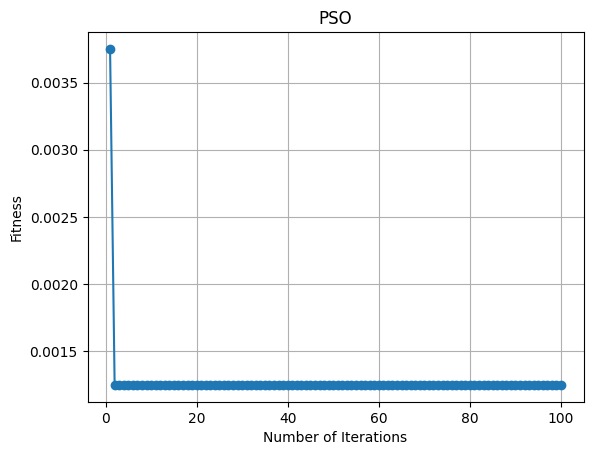

In [ ]:
# perform feature selection
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
start_time = time.time()
fmdl  = jfs(X_train, y_train, opts)
print("Run Time --- %s seconds ---" % (time.time() - start_time))

sf    = fmdl['sf']

# model with selected features
num_train = np.size(xtrain, 0)
num_valid = np.size(xtest, 0)
x_train   = xtrain[:, sf]
y_train   = ytrain.reshape(num_train)  # Solve bug
x_valid   = xtest[:, sf]
y_valid   = ytest.reshape(num_valid)  # Solve bug

mdl       = LinearRegression()
mdl.fit(x_train, y_train)

# accuracy
y_pred    = mdl.predict(x_valid)
RMSE       = mean_squared_error(y_valid, y_pred, squared=False)
print("RMSE:", RMSE)
from sklearn.metrics import r2_score
r2 = r2_score(y_valid,y_pred) * 100
relative_error = np.abs((y_valid - y_pred) / y_valid)
mean_relative_error = mean_absolute_error(y_valid, y_pred)
median_relative_error = median_absolute_error(y_valid, y_pred)
#print("Relative Error:", relative_error)
print("Mean Magnitude of Relative Error:", mean_relative_error)
print("Median Magnitude of Relative Error:", median_absolute_error(y_valid, y_pred))
print("R squared : " ,r2_score(y_valid,y_pred))
print("Mean square error: ", mean_squared_error(y_valid, y_pred))
print("Root mean square error: ", np.sqrt(mean_squared_error(y_valid, y_pred)))
#print("Mean Absolute error : ", mean_absolute_error(y_test, yhat) * 100)
print("Mean magnitude of percentage error :" , mean_absolute_percentage_error(y_valid, y_pred))

# number of selected features
num_feat = fmdl['nf']
print("Feature Size:", num_feat)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [ ]:
fmdl['sf']

array([7])

In [ ]:
X_test = train_df
Y_test = X_test['Effort'].values
#X_test   = X_test[:, sf]
sc = StandardScaler()
X_test = sc.fit_transform(X_test)